In [4]:
import sys
sys.path.insert(0, '../tools/')
from utils import fft_price, get_data_folder, put2call, residual_heston_diff_ev, plot_params, residual_heston
from hyperopt import fmin, Trials, hp, STATUS_OK, tpe
from scipy.stats import ttest_ind
from functools import partial
import seaborn as sns
from numpy.random import rand
import numpy as np
from time import time
from matplotlib import pyplot as plt
import sklearn.metrics as mets
import pandas as pd
from scipy.optimize import least_squares, differential_evolution, minimize, BFGS
sns.set(style="whitegrid")

In [5]:
# folder = '../data/'
# data = get_data_folder(folder, False)
# data = put2call(data)
# print("Total values for training", len(data))
# data.describe()

# Speed of ANN

In [6]:
# import tensorflow as tf
# from time import time
# import numpy as np
# import seaborn as sns
# recordings = []
# for x in range(50):
#     train_ds = tf.random.uniform([100,9])
#     t0 = time()
#     model.model(train_ds)
#     recordings.append(time()-t0)

## Speed of fft_function

In [7]:
import numpy as np
from scipy import stats
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)

var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

s = np.sqrt((var_a + var_b)/2)
## Calculate the t-statistics
t = (a.mean() - b.mean())/(s*np.sqrt(2/N))
## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a,b)
print("t = " + str(t2))
print("p = " + str(p2))
print(ttest_ind(a, b))

t = 2.5979151552299315
p = 0.01817886831611193
t = 2.5979151552299315
p = 0.018178868316112064
Ttest_indResult(statistic=2.5979151552299315, pvalue=0.018178868316112064)


C:\ProgramData\Anaconda3\envs\ratulz\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Time (seconds)')

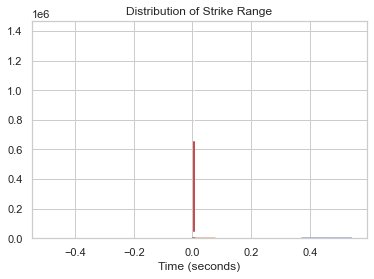

In [6]:
total_times = []
partial_times = []
for _ in range(50):
    data_points = 100
    r = (rand(data_points)/100*5).round(4)
    q = (rand(data_points)/100*5).round(4)
    K = [1]*data_points
    S0 = ((rand(data_points)*(1.4-.6))+.6).round(4)
    T = ((rand(data_points)*(3-.05))+.05).round(4)
    v0 = ((rand(data_points)*(.5-.01))+.01)
    sig = (np.sqrt(v0)).round(4)
    th = (rand(data_points)*(.8-.01) + .01).round(5)
    ka = (rand(data_points)*2+1).round(4)
    rho = (rand(data_points)*-.9).round(4)
    eta = ((rand(data_points)*(.5-.01))+.01).round(4)
    t_tot_init = time()
    for x in range(data_points):
        t_par_init = time()
        fft_price(S0[x], r[x], q[x], K[x], T[x], 'Heston',callput='c', diag = False, 
                  sig=sig[x], th=th[x],ka=ka[x],rho=rho[x],eta=eta[x])
        t_par_fin = time()
        partial_times.append(t_par_fin-t_par_init)
    t_tot_fin = time()
    total_times.append(t_tot_fin-t_tot_init)
plot_global = sns.distplot(total_times)
plot_global.set_title('Distribution of Global Measurements')
plt.xlabel('Time (seconds)')
# plot_global.figure.savefig("Global_measurements.png")
plot_local = sns.distplot(partial_times)
plot_local.set_title('Distribution of Local Measurements')
plt.xlabel('Time (seconds)')
# plot_local.figure.savefig("Local_mesurements.png")
exta_times = []
for x in range(50):
    r = .01
    q = .05
    K = rand(100)
    S0 = 20
    T = .7
    v0 = .3
    sig = .5
    th = .5
    ka = 2
    rho = -.5
    eta = .5
    t0 = time()
    fft_price(S0, r, q, K, T, 'Heston',callput='c', diag = False, 
                      sig=sig, th=th,ka=ka,rho=rho,eta=eta)
    exta_times.append(time()-t0)
    plot_local = sns.distplot(exta_times)
plot_local.set_title('Distribution of Strike Range')
plt.xlabel('Time (seconds)')
# plot_local.figure.savefig("Strike_range.png")

In [13]:
recordings = np.load('./ann_perf.npy')

In [22]:
ttest_ind(recordings, exta_times)

Ttest_indResult(statistic=-33.57608966419057, pvalue=1.4730151597256395e-55)

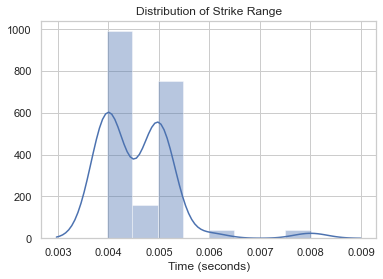

## Differential Evolution

In [4]:
len_data = 80

time_diff_ev = []
results = []
Vars = [data.strike, data.rate, data.time_maturity, data.dividend]
K, r, T, q = list(map(lambda x: x.tolist()[:len_data],Vars))
S0 = np.mean(data.price)
Y = data.call_price.tolist()[:len_data]

# for _ in range(1):
#     t0 = time()
#     res = differential_evolution(func = residual_heston_diff_ev,args=(K,r,T,S0,q,Y,'c',True),disp=True,
#                                    bounds = [[0.2, 0.8], [0.01, 0.8], [0.0, 3.0], [-0.9, 0.0], [0.01, 0.5]], 
#                                    popsize=50,workers=-1)
#     time_diff_ev.append(time()-t0)
#     results.append(res)

In [5]:

trials = Trials()
space_heston = {'sig': hp.uniform('sig', .2, .8),
               'th': hp.uniform('th', .01, .8),
               'ka': hp.uniform('ka', 0, 3),
               'rho': hp.uniform('rho', -.9, 0),
               'eta': hp.uniform('eta', 0.01, .5),}

def objective_heston(params,K,r,T,S0,q,Y,callput,diag):
    '''
    Residual function for the Heston parameter optimization.
    '''
    Y_pred = fft_price(S0=S0,r=r, q=q, K=K, T=T, model_name='Heston',
                       callput=callput,diag=diag,**params).reshape(-1,)
    if sum(~np.isfinite(Y_pred.reshape(-1,)))>0:
        Y_pred[~np.isfinite(Y_pred)] = 9e30
    err = sum((Y-Y_pred)**2)/len(Y)
    return {'loss': err, 'parameters': params, 'status': STATUS_OK, 'preds':Y_pred}

fmin_objective_heston = partial(objective_heston, K=K, r=r, T=T, 
                                S0=S0, q=q, Y=Y, callput='c',
                                diag='true')
# hyperopt optimization
best = fmin(fmin_objective_heston, space_heston, algo=tpe.suggest, 
            trials=trials, max_evals=50)
x0 = (best['sig'], best['th'], best['ka'], best['rho'], best['eta'])
min(trials.losses())

t0 = time()
res = minimize(fun=residual_heston_diff_ev,x0=x0, 
                 args=(K,r,T,S0,q,Y,'c',True),
                 options={'disp':True},
                 method='BFGS',
                 hess=BFGS
                )
print("time taken: %s" %(time()-t0))
t0 = time()
res = least_squares(fun=residual_heston,x0=x0,
                    args=(K,r,T,S0,q,Y,'c',True),
                   method='lm')
print("time taken: %s" %(time()-t0))

t0 = time()
res = least_squares(fun=residual_heston,x0=x0,
                    args=(K,r,T,S0,q,Y,'c',True),
                    bounds = [[.2,0.01,0,-.9,0.01],[.8,.8,3,0,.5]],
                    method='trf')
print("time taken: %s" %(time()-t0))

100%|████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.27trial/s, best loss: 1.2431775229464634]


C:\ProgramData\Anaconda3\envs\ratulz\lib\site-packages\scipy\optimize\_minimize.py:511: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)
../tools\utils.py:50: RuntimeWarning: overflow encountered in exp
  * np.exp(sig**2*th**-2*(ka - rho*th*i*u - d)*(1 - np.exp(-d*t))/(1 - g*np.exp(-d*t)))
../tools\utils.py:50: RuntimeWarning: overflow encountered in multiply
  * np.exp(sig**2*th**-2*(ka - rho*th*i*u - d)*(1 - np.exp(-d*t))/(1 - g*np.exp(-d*t)))
../tools\utils.py:50: RuntimeWarning: invalid value encountered in multiply
  * np.exp(sig**2*th**-2*(ka - rho*th*i*u - d)*(1 - np.exp(-d*t))/(1 - g*np.exp(-d*t)))
../tools\utils.py:122: RuntimeWarning: invalid value encountered in multiply
  op = partialop * hestonfftcf(u=u, S0=S0, r=r, t=T, q=q, **kwargs)


         Current function value: 1.097044
         Iterations: 36
         Function evaluations: 683
         Gradient evaluations: 96
time taken: 196.08665132522583
time taken: 164.92680478096008
time taken: 15.483593463897705


In [6]:
plot_params(res.x,data)

In [7]:
plot_params(x0,data)

In [8]:
def evaluate_on_test_1(parameters):
    if len(parameters.shape)==2:
        num_params = parameters.shape[0]
    else: num_params = 1;parameters=[parameters]
    data = pd.read_csv('testing_set_1.csv')
    Vars = [data.strike, data.rate, data.time_maturity, data.dividend]
    K, r, T, q = list(map(lambda x: x.tolist(),Vars))
    S0 = np.mean(data.price)
    Y = data.call_price.tolist()
    errors = {'MSE':[],
              'MAPE': [],
              'MAE': []}
    for i in range(num_params):
        sig, th, ka, rho, eta = parameters[i]
        Y_pred = fft_price(S0=S0,r=r, q=q, K=K, T=T, model_name='Heston',
                   sig = sig,th=th,ka=ka,rho=rho,eta=eta,
                   callput='c',diag=True).reshape(-1,)
        mse = sum((Y-Y_pred)**2)/len(Y)
        mae = sum(np.abs(Y-Y_pred))/len(Y)
        mape = sum(np.abs((Y-Y_pred)/Y))/len(Y)
        errors['MSE'].append(mse)
        errors['MAE'].append(mae)
        errors['MAPE'].append(mape)
    return errors

In [9]:
evaluate_on_test_1(res.x)

{'MSE': [1.9381842532957263],
 'MAPE': [0.13783403761500937],
 'MAE': [0.8672763004152119]}

In [10]:
errors = evaluate_on_test_1(np.array(x0))

In [11]:
pd.DataFrame(errors).agg(['mean','std'])

MSE      MAPE       MAE
mean  2.050851  0.147021  1.012572
std        NaN       NaN       NaN

In [12]:
len(trials.trials)

50